In [1]:
import os
import yaml
import math
import fitz
import copy
import json
import tqdm
import pickle
import random
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

In [3]:
with open("config.yaml") as stream:
    try:
        config = yaml.safe_load(stream)
        print(json.dumps(config, indent=4))
    except yaml.YAMLError as exc:
        print(exc)

{
    "size": {
        "width": [
            600,
            1200
        ],
        "ratio": [
            0.7,
            1.5
        ],
        "max_height": 3000
    },
    "languages": [
        "Ch",
        "En"
    ],
    "title": {
        "method": "figure",
        "method_text": {
            "Ch_path": "/mnt/hwfile/opendatalab/kanghengrui/data/source/text/Chinese/title",
            "En_path": "/mnt/hwfile/opendatalab/kanghengrui/data/source/text/English/title",
            "fontsize": [
                18,
                36
            ]
        },
        "method_figure": {
            "path": "/mnt/petrelfs/zhaozhiyuan/layout/pretrain_layout/material/title",
            "ratio_step": 0.2,
            "area_step": 500
        }
    },
    "maintext": {
        "fontsize": [
            10,
            12
        ],
        "Ch_path": "/mnt/hwfile/opendatalab/kanghengrui/data/source/text/Chinese/maintext",
        "En_path": "/mnt/hwfile/opendatalab/kanghengrui/data/

### cc3m

In [3]:
print(len(os.listdir("/mnt/hwfile/opendatalab/zhaozhiyuan/cc3m")))

2781821


In [4]:
IMAGE_PATH = config["image"]["path"]
IMAGE_RATIO_STEP = config["image"]["ratio_step"]
IMAGE_AREA_STEP = config["image"]["area_step"]

In [5]:
ratio_range = np.arange(0, 5, IMAGE_RATIO_STEP)
area_range = np.arange(0, 800000, IMAGE_AREA_STEP)
image_search_dict = {}
for r in ratio_range:
    image_search_dict[r] = {}
    for area in area_range:
        image_search_dict[r][area] = []

In [6]:
from utils.get_image_size import get_image_size
ratio_all, area_all = [], []
for f in tqdm.tqdm(os.listdir(IMAGE_PATH)):
    if "ipynb" in f:
        continue
    size = get_image_size(os.path.join(IMAGE_PATH, f))
    ratio = size[0]/size[1] # w/h
    area = size[0]*size[1]
    ratio_all.append(ratio)
    area_all.append(area)
    min_ratio = min(ratio_range, key=lambda x:abs(x-ratio))
    min_area = min(area_range, key=lambda x:abs(x-area))
    image_search_dict[min_ratio][min_area].append(f)

  0%|                                                                                                                                                                                   | 0/2781821 [00:00<?, ?it/s]

> /mnt/petrelfs/zhaozhiyuan/layout/pretrain_layout/utils/get_image_size.py(106)get_image_metadata()
    104     with io.open(file_path, "rb") as input:
    105         pdb.set_trace()
--> 106         return get_image_metadata_from_bytesio(input, size, file_path)
    107 
    108 



ipdb>  p input


<_io.BufferedReader name='/mnt/hwfile/opendatalab/zhaozhiyuan/cc3m/00001a42a8cfc112dca8f615bad5af2b.jpg'>


ipdb>  p type(input)


<class '_io.BufferedReader'>


ipdb>  q


  0%|                                                                                                                                                                                 | 0/2781821 [1:07:28<?, ?it/s]


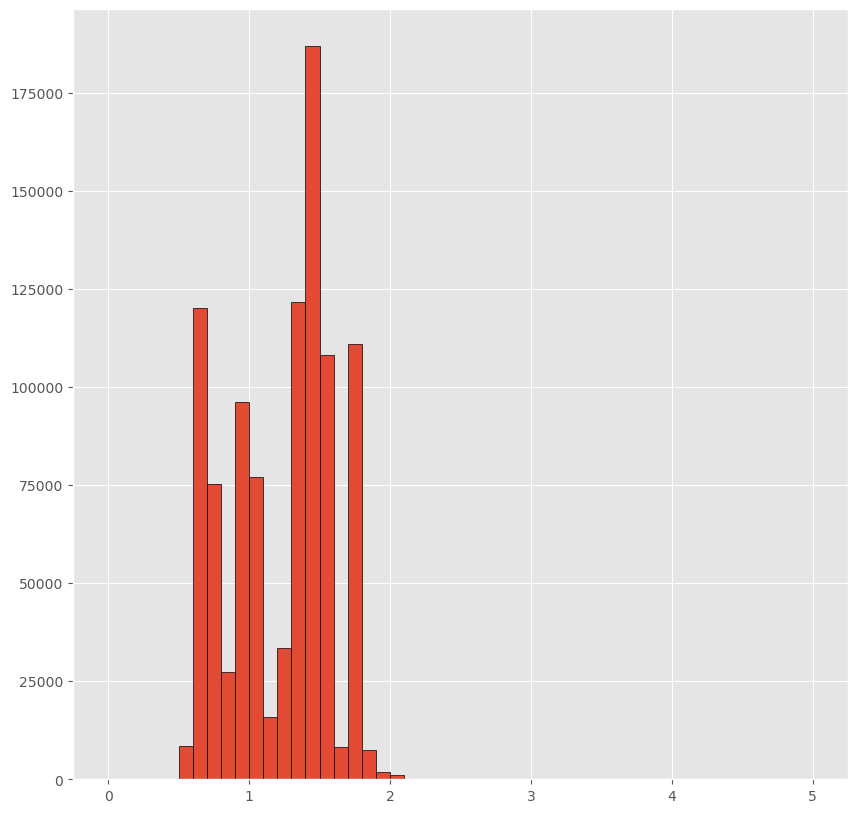

In [30]:
plt.style.use("ggplot")
plt.figure(figsize=[10,10])
plt.hist(ratio_all, bins=ratio_range.shape[0], range=(0, 5), edgecolor='black')
plt.show()

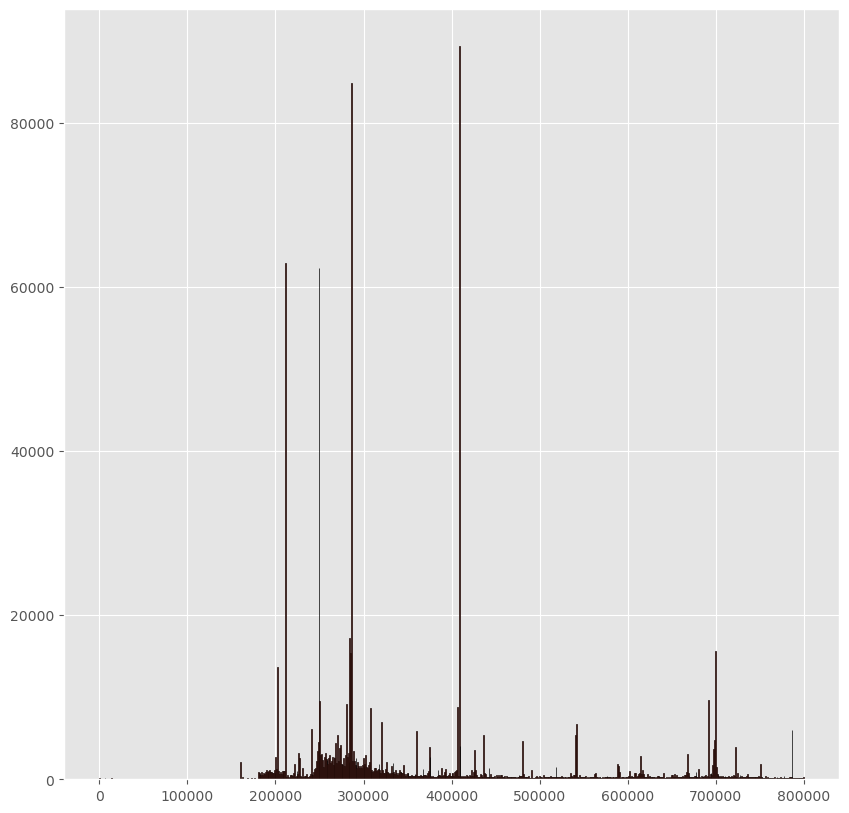

In [31]:
plt.style.use("ggplot")
plt.figure(figsize=[10,10])
plt.hist(area_all, bins=area_range.shape[0], range=(0, 800000), edgecolor='black')
plt.show()

In [34]:
with open("image_material_map.pt", "wb") as f:
    pickle.dump(image_search_dict, f)

### laion

In [3]:
import cv2
import pandas as pd
from petrel_client.client import Client

In [4]:
def read_from_ceph(client, path):
    img_bytes = client.get(path)
    assert(img_bytes is not None)
    img_mem_view = memoryview(img_bytes)
    img_array = np.frombuffer(img_mem_view, np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    return img

In [5]:
conf_path = '~/petreloss.conf'
client = Client(conf_path) # 若不指定 conf_path ，则从 '~/petreloss.conf' 读取配置文件

In [6]:
IMAGE_PATH = config["image"]["path"]
IMAGE_RATIO_STEP = config["image"]["ratio_step"]
IMAGE_AREA_STEP = config["image"]["area_step"]

In [7]:
ratio_range = np.arange(0, 5, IMAGE_RATIO_STEP)
area_range = np.arange(0, 800000, IMAGE_AREA_STEP)
image_search_dict = {}
for r in ratio_range:
    image_search_dict[r] = {}
    for area in area_range:
        image_search_dict[r][area] = []

In [19]:
from utils.get_image_size import get_image_size
ratio_all, area_all = [], []
laion1m = pd.read_csv("laion_1m.csv")
for row_id in tqdm.tqdm(range(laion1m.shape[0])):
    data = laion1m.iloc[row_id]
    path = data["path"]
    try:
        size = get_image_size(file_path=path, client=client)
    except BaseException:
        continue
    ratio = size[0]/size[1] # w/h
    area = size[0]*size[1]
    ratio_all.append(ratio)
    area_all.append(area)
    min_ratio = min(ratio_range, key=lambda x:abs(x-ratio))
    min_area = min(area_range, key=lambda x:abs(x-area))
    image_search_dict[min_ratio][min_area].append(path)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [14:34:33<00:00, 19.06it/s]


In [9]:
from utils.get_image_size import get_image_size
ratio_all, area_all = [], []
for f in tqdm.tqdm(os.listdir(IMAGE_PATH)):
    if "ipynb" in f:
        continue
    try:
        size = get_image_size(os.path.join(IMAGE_PATH, f))
    except BaseException:
        continue
    ratio = size[0]/size[1] # w/h
    area = size[0]*size[1]
    ratio_all.append(ratio)
    area_all.append(area)
    min_ratio = min(ratio_range, key=lambda x:abs(x-ratio))
    min_area = min(area_range, key=lambda x:abs(x-area))
    image_search_dict[min_ratio][min_area].append(f)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 986656/986656 [42:28<00:00, 387.15it/s]


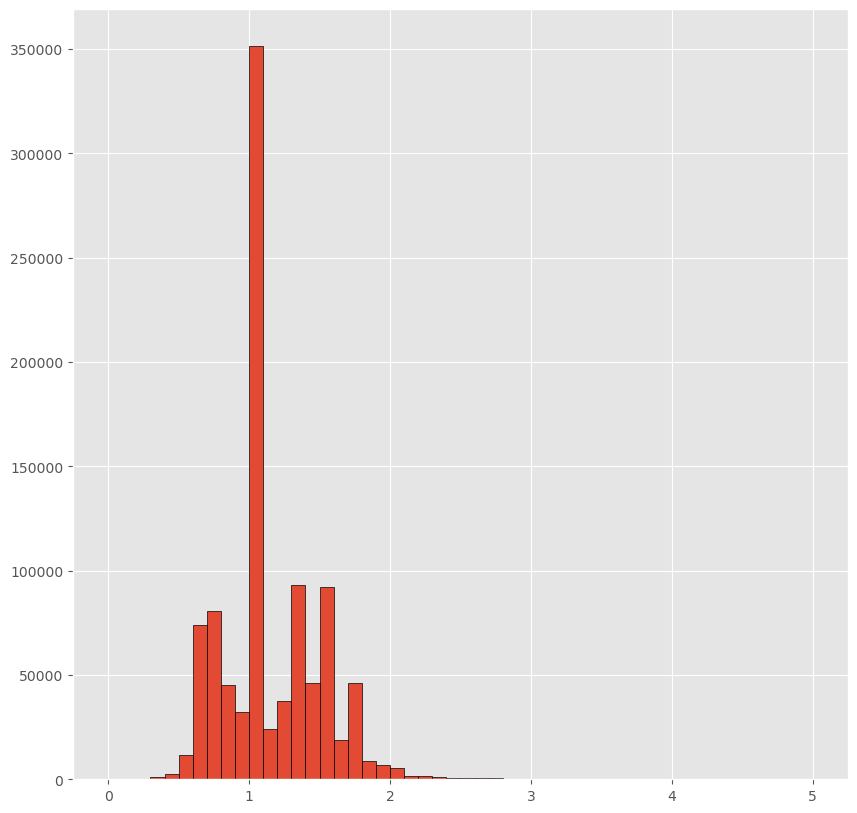

In [10]:
plt.style.use("ggplot")
plt.figure(figsize=[10,10])
plt.hist(ratio_all, bins=ratio_range.shape[0], range=(0, 5), edgecolor='black')
plt.show()

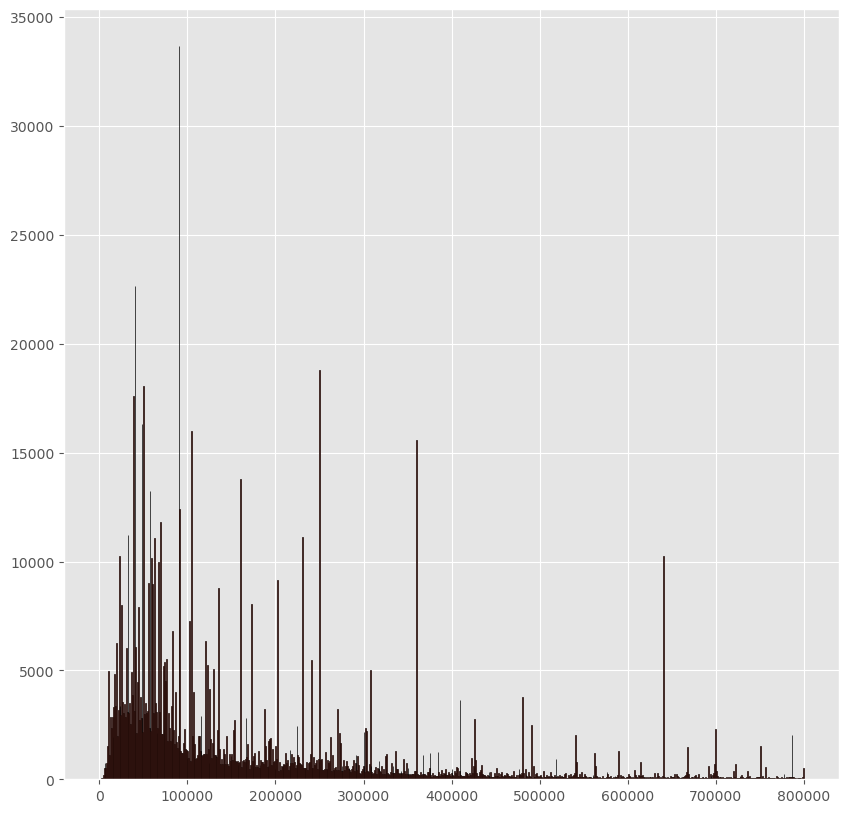

In [11]:
plt.style.use("ggplot")
plt.figure(figsize=[10,10])
plt.hist(area_all, bins=area_range.shape[0], range=(0, 800000), edgecolor='black')
plt.show()

In [12]:
with open("laion1m_material_map.pt", "wb") as f:
    pickle.dump(image_search_dict, f)

### chart image

In [4]:
IMAGE_PATH = config["image"]["path"]
IMAGE_RATIO_STEP = config["image"]["ratio_step"]
IMAGE_AREA_STEP = config["image"]["area_step"]

In [5]:
ratio_range = np.arange(0, 5, IMAGE_RATIO_STEP)
area_range = np.arange(0, 800000, IMAGE_AREA_STEP)
image_search_dict = {}
for r in ratio_range:
    image_search_dict[r] = {}
    for area in area_range:
        image_search_dict[r][area] = []

In [6]:
from utils.get_image_size import get_image_size
ratio_all, area_all = [], []
for f in tqdm.tqdm(os.listdir(IMAGE_PATH)):
    if "ipynb" in f:
        continue
    size = get_image_size(os.path.join(IMAGE_PATH, f))
    ratio = size[0]/size[1] # w/h
    area = size[0]*size[1]
    ratio_all.append(ratio)
    area_all.append(area)
    min_ratio = min(ratio_range, key=lambda x:abs(x-ratio))
    min_area = min(area_range, key=lambda x:abs(x-area))
    image_search_dict[min_ratio][min_area].append(f)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 185541/185541 [05:49<00:00, 530.32it/s]


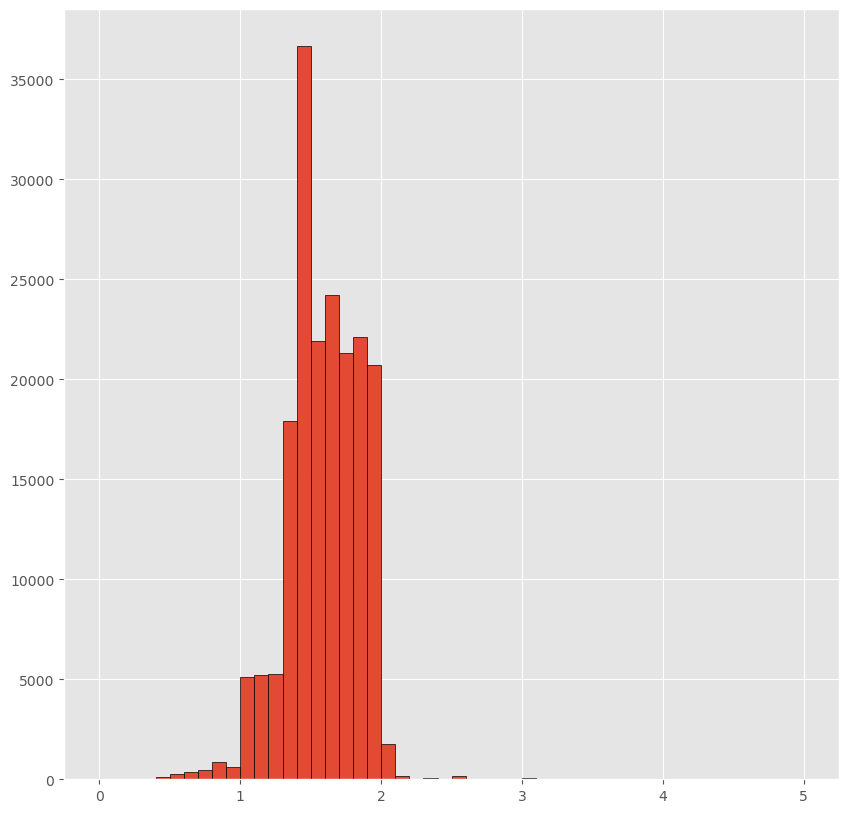

In [7]:
plt.style.use("ggplot")
plt.figure(figsize=[10,10])
plt.hist(ratio_all, bins=ratio_range.shape[0], range=(0, 5), edgecolor='black')
plt.show()

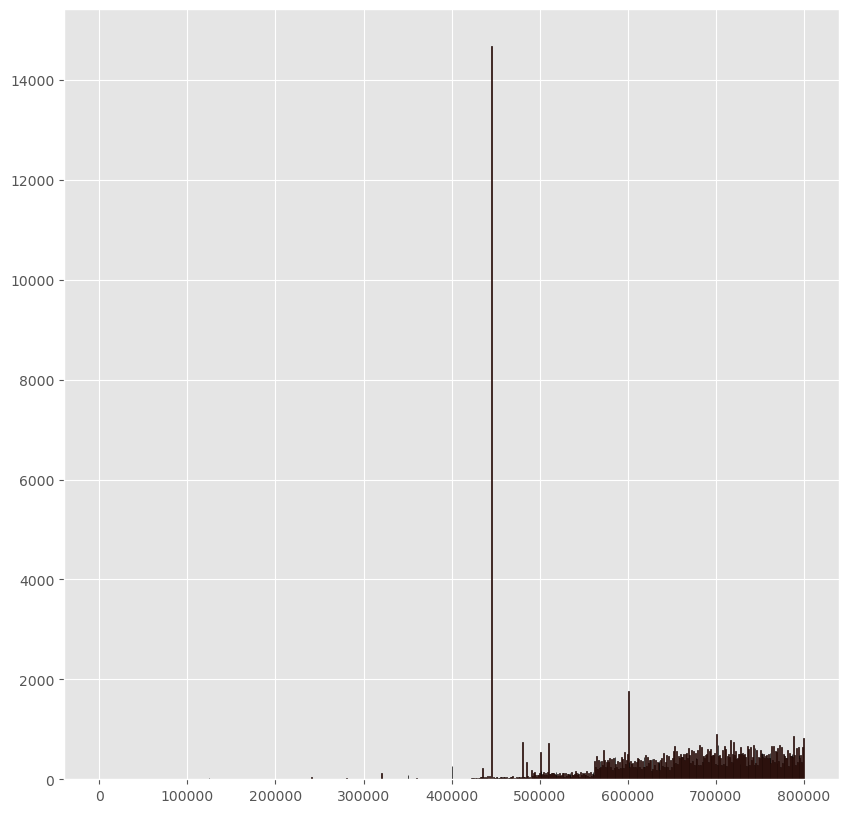

In [8]:
plt.style.use("ggplot")
plt.figure(figsize=[10,10])
plt.hist(area_all, bins=area_range.shape[0], range=(0, 800000), edgecolor='black')
plt.show()

In [9]:
with open("chart_material_map.pt", "wb") as f:
    pickle.dump(image_search_dict, f)